In [150]:
import torch
from torch import nn
from d2l import torch as d2l

LLMs for Distribution modeling

$$P(x_1, \ldots, x_T) = P(x_1) \prod_{t=2}^T P(x_t \mid x_{t-1}, \ldots, x_1)$$ 

Lets create the seq-data

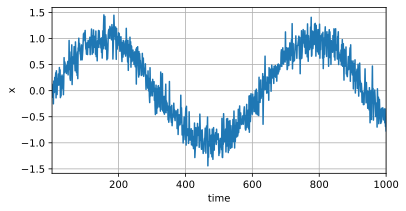

In [151]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        super().__init__()
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2


data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


The sin has period 600 and we create an iterator for it.  
The sequence has been split it sequences of τ.

In [152]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)


In [153]:
# Assume x and y are tensors of shape [2, 3]
x = torch.tensor([[1, 2, 3], 
                  [4, 5, 6]])
y = torch.tensor([[7, 8, 9],
                  [10, 11, 12]])
# y2 = torch.tensor([[13, 14, 15],
#                   [16, 17, 18]])
z = torch.stack([x, y], dim=1)
# z will have shape [2, 2, 3]
z[:,:,:]

tensor([[[ 1,  2,  3],
         [ 7,  8,  9]],

        [[ 4,  5,  6],
         [10, 11, 12]]])

In [154]:
# Custom model with some non-linearity just to test what happens
import torch.nn as nn
import torch

class EnhancedRegression(d2l.Module):
    """A more complex regression model with additional layers and ReLU activations,
    implemented using high-level APIs.

    Defined in :numref:`sec_linear_concise`"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyLinear(10),  # Lazy initialization for an input layer with 4 outputs
            nn.ReLU(),         # Another non-linear activation function
            nn.LazyLinear(1)    # Output layer producing 1 output
        )
        self.initialize_weights()

    def initialize_weights(self):
        """Initialize weights and biases with normal and zero values respectively."""
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.fill_(0)

    def forward(self, X):
        """Forward pass through the network."""
        return self.net(X)

    def loss(self, y_hat, y):
        """Mean squared error loss."""
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        """SGD optimizer."""
        return torch.optim.SGD(self.parameters(), self.lr)


In [155]:
# model = d2l.LinearRegression(lr=0.01)
model = EnhancedRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

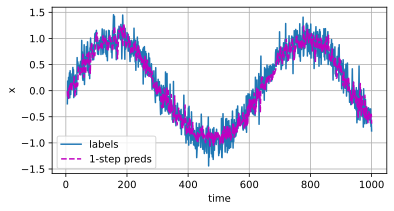

In [156]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))


Making predictions many steps ahead just with linear regression... is bad...

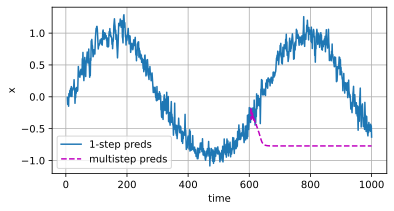

In [157]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
# here uses values extracted from the past(trained up to 600) to predict the future
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))


933


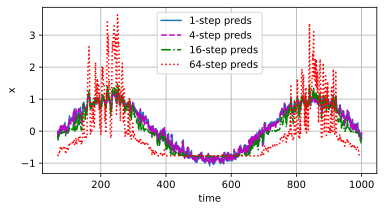

In [158]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        # the reason we stack in dim=1 is to preduce preds for every number
        # up until k so if k =64 we also have prediction for 20 or 4 or 
        # whatever number we may wish because we have stacked in dim=1
        # Thats also the reason that all the predictions even the ones that 
        # predict with k < 64 have length 999-64, because we have an offset of
        # the highest k.
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.flatten())
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
print(len(preds[1]))
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))
